### Neurala Nätverk är modeller för Allmän Linjär Regression 

<img src="../Data/mlpnn.jpg">

Ŷ = φ (XW + b)

att jämföra med

$\hat{Y} = \beta_0 + \beta_1X_1 …$

Varje $x_i w_{ij} + b_i$ är alltså en linje! Om aktiveringsfunktionen är linjär, så är hela systemet verkligen "bara" en multipel linjär regression.

### Ickelinjäritet

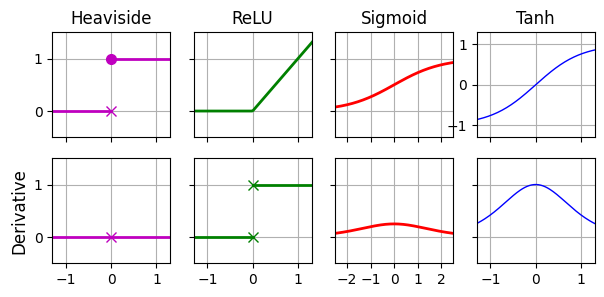

In [177]:
# activation functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 2.5
z = np.linspace(-max_z, max_z, 200)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 3))

axes[0, 0].plot([-max_z, 0], [0, 0], "m-", linewidth=2)
axes[0, 0].plot(0, 0, "mx", markersize=7)
axes[0, 0].plot(0, 1, "mo", markersize=7)
axes[0, 0].plot([0, max_z], [1, 1], "m-", linewidth=2)
axes[0, 0].set_title("Heaviside", fontsize=12)
axes[1, 0].plot(z, derivative(np.sign, z), "m-", linewidth=2)
axes[1, 0].plot(0, 0, "mx", markersize=7)
axes[1, 0].set_ylabel("Derivative", fontsize=12)

axes[0, 1].plot(z, relu(z), "g-", linewidth=2)
axes[0, 1].set_title("ReLU", fontsize=12)
axes[1, 1].plot([-max_z, 0], [0, 0], "g-", linewidth=2)
axes[1, 1].plot([0, max_z], [1, 1], "g-", linewidth=2)
axes[1, 1].plot(0, 0, "gx", markersize=7)
axes[1, 1].plot(0, 1, "gx", markersize=7)

axes[0, 2].plot(z, sigmoid(z), "r-", linewidth=2)
axes[0, 2].set_title("Sigmoid", fontsize=12)
axes[1, 2].plot(z, derivative(sigmoid, z), "r-", linewidth=2)

axes[0, 3].plot(z, np.tanh(z), "b-", linewidth=1)
axes[0, 3].set_title("Tanh", fontsize=12)
axes[1, 3].plot(z, derivative(np.tanh, z), "b-", linewidth=1)

for row in range(2):
    for col in range(4):
        axes[row, col].grid(True)
        if row == 0:
            axes[row, col].set_xticklabels([])
        if col == 2:
            axes[row, col].set_xlim(-max_z, max_z)
            axes[row, col].set_xticks([-2, -1, 0, 1, 2])
        else:
            axes[row, col].set_xlim(-1.3, 1.3)
            axes[row, col].set_xticks([-1, 0, 1])
        if col != 0 and ((row, col) != (0, 3)):
            axes[row, col].set_yticklabels([])
        if (row, col) == (0, 3):
            axes[row, col].set_ylim(-1.3, 1.3)
            axes[row, col].set_yticks([-1, 0, 1])
        else:
            axes[row, col].set_ylim(-0.5, 1.5)
            axes[row, col].set_yticks([0, 1])

plt.show()



Men vi löser inte detta system med statistisk anpassning. Inte minst kan vi inte hantera diskontinuerliga aktiveringsfunktioner med OLS eller MLE! Med numeriska närmevärden kommer vi undan detta, vilket är matematisk krångligt men praktiskt bekvämt.

Idéen är på ytan enkel, men matematiskt väldigt svårbegriplig! Se Appendix A i boken -- matematiken är mer än vi klarar med algebran vi lärt oss. Framör allt måste vi använda hyperkomplexa tal (_dualer_). För den hugade som inte är rädd för abstrakt algebra har Dr [Michael Penn](https://www.youtube.com/watch?v=ceaNqdHdqtg) en video om dem. Det finns andra enklare videor på youtube, men de begrepp som Dr Penn går igenom är det som faktiskt krävs för att kunna använda dem på egen hand.

I korta; dualer är en sorts tal som har "fler nollor" än vanliga tal. Specifikt finns en särskild symbol $\epsilon$ som har egenskapen $\epsilon^2 = 0$ (jämför med komplexa tal $i^2 = -1$).


<small>Överkurs <br />
En formulering i linjär algebra:
Icke-linjäritet leder till att nollrummets dimension exploderar; det finns alltså fler och fler icke-lösningar. Detta innebär att Jordan dekompositionen inte längre skulle vara nilpotent och vi hamnar i "curse of dimensionality", dvs hittar bara icke-lösningar. Med dualer avbildar vi nollrummet på ett delrum som är nilpotent! Därmed kan vi derivera även icke-kontinuerliga aktiveringsfunktioner, och hitta linjära approximationer till vad som helst i ett litet område kring testdatan! Vi kan till och med formulera det som Taylor-expansion och återsälla Kolmogorovs representationsteorem --> Universal Approximation Theorem för feed-forward NN.
</small>

Istället för att beräkna lutningen på alla linjerna separat, så uppskattar vi lutningarna (vikterna $w_{ij}$) för alla noder på en gång. Detta sker genom två pass genom nätverket: 
* I framåt riktningen beräknas alla noders värden (dvs $x_iw_{ij} + b_i$)
* I bakåt riktningen beräknas de partiella derivatorna för hela det multipla linjära systemet genom en hyperkomplex beräkningsgraf

Detta kallas <em>reverse-mode auto-diff</em>.

Nästa steg för att få en fungerande algoritm för att träna ett NN är att utföra <em>gradient descent</em>, dvs: 
* Justera vikterna $w_{ij}$ ett litet steg i den beräknade gradientens riktning. 

Upprepa!

När vi når något stopp-villkor så är vi klara. Detta kallas 'backpropagation'.

Notera att inget sades om vilken <em>sorts</em> gradient descent som används. I praktiken är <em>mini-batch gradient descent</em> det som är effektivast att köra på GPUer, men särskilt på CPU kan en sann stokastisk gradient descent (där vi alltså sätter någon sannolikhet för varje nod att vara med eller inte) vara lämplig. Detta är mindre sannolikt idag, eftersom även CPUer är väldigt parallella med dussintals, eller till och med hundratals, processorkärnor. 


Modern hårdvara är riktigt snabb, både CPU och GPU. På en AMD 7800X3D/7900GRE (en speldator som är en generation gammal och i näst högsta klassen av den generationens hårdvara) så är prestandan 8x högre för CPU och 4x snabbare för GPU än en gratisinstans på Colab (nVidia T4).

In [178]:
import torch
device = "cuda"

In [179]:
M = torch.rand((1000,1000))
M @ M.T # uppvärming; låter X3D cachen på CPU fyllas
%timeit M @ M.T

M = M.to(device)
M @ M.T # låter GDDR-cache på GPU fyllas
%timeit M @ M.T

2.04 ms ± 41.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
146 μs ± 10 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Att jämföra med Colab: <br />
16.1 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)<br /> 
549 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Notera att AMD/ROCM exekverar annorlunda: 10x fler loopar som var och en tar längre tid men totalt är 7900GRE mycket snabbare än en T4 (och halva priset).

Sklearn har enklare neurala nätverk, men de är väldigt begränsade. Låt oss undersöka dem först, och sedan börja implementera samma sak fast med pytorch. 

In [180]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [181]:
housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)

In [182]:
housing.feature_names, housing.target_names

(['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 ['MedHouseVal'])

In [183]:
# in och ut dimensioner räknas ut automatiskt! ReLU mellan dolda lager, linjärt ut och in
# early stopping för att undvika overfit
mlp_reg = MLPRegressor(hidden_layer_sizes=[50,50,50], early_stopping=True, verbose=True)

In [184]:
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)

Iteration 1, loss = 0.79617586
Validation score: 0.528151
Iteration 2, loss = 0.28600398
Validation score: 0.658829
Iteration 3, loss = 0.23285933
Validation score: 0.703105
Iteration 4, loss = 0.21235859
Validation score: 0.716327
Iteration 5, loss = 0.19973506
Validation score: 0.731449
Iteration 6, loss = 0.19073829
Validation score: 0.737001
Iteration 7, loss = 0.18420160
Validation score: 0.745172
Iteration 8, loss = 0.17854681
Validation score: 0.756984
Iteration 9, loss = 0.17495476
Validation score: 0.762375
Iteration 10, loss = 0.17024707
Validation score: 0.765638
Iteration 11, loss = 0.16166170
Validation score: 0.769617
Iteration 12, loss = 0.15872295
Validation score: 0.767567
Iteration 13, loss = 0.15516795
Validation score: 0.778325
Iteration 14, loss = 0.15366290
Validation score: 0.780141
Iteration 15, loss = 0.15276804
Validation score: 0.777266
Iteration 16, loss = 0.14941943
Validation score: 0.783255
Iteration 17, loss = 0.14921980
Validation score: 0.782042
Iterat

,steps,"[('standardscaler', ...), ('mlpregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,hidden_layer_sizes,"[50, 50, ...]"
,activation,'relu'
,solver,'adam'


In [185]:
mlp_reg.best_validation_score_

0.8070396473479668

In [186]:
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

In [187]:
rmse

0.5167415207390517

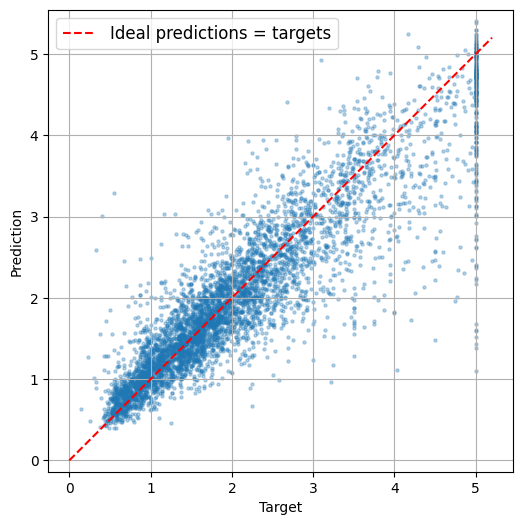

In [188]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=5, alpha=0.3)
plt.plot([0, 5.2], [0,5.2], color='red', linestyle='--', label="Ideal predictions = targets")
plt.axis("equal")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend(fontsize=12)
plt.grid()
plt.show()

### Klassificering

In [189]:
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="fashion-mnist", as_frame=False, parser="liac-arff")
targets = fashion_mnist.target.astype(int)


In [190]:
X_train, y_train = fashion_mnist.data[100:60_000], targets[100:60_000]
X_test , y_test = fashion_mnist.data[60000:], targets[60000:]
X_val, y_val = fashion_mnist.data[:100], targets[:100]

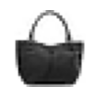

In [191]:
X_sample = X_train[0].reshape(28,28)
plt.figure(figsize=(1,1))
plt.imshow(X_sample, cmap="binary")
plt.axis('off')
plt.show()

In [192]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [193]:
class_names[y_train[0]]

'Bag'

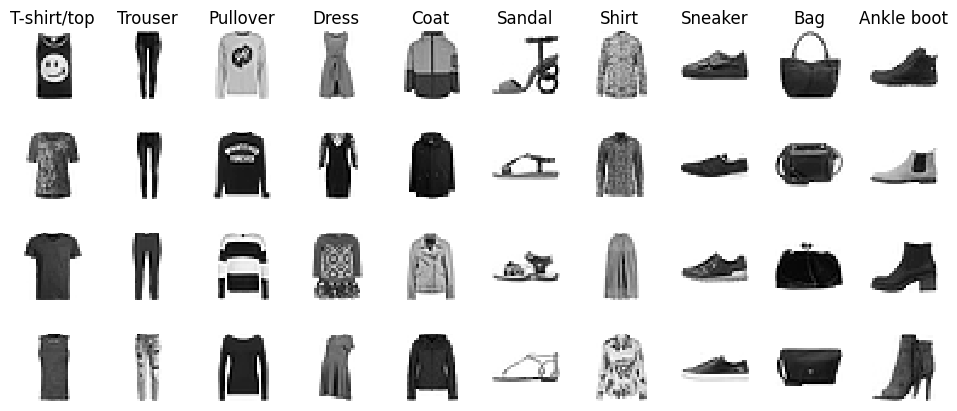

In [194]:
n_rows = 4
plt.figure(figsize=(12, n_rows*1.2))
for row in range(n_rows):
    for class_index in range(10):
        X_img = X_train[y_train==class_index][row].reshape(28, 28)
        y_img = y_train[y_train==class_index][row]
        plt.subplot(n_rows, 10, 10 *row + class_index + 1)
        plt.imshow(X_img, cmap="binary", interpolation="nearest")
        plt.axis('off')
        if row == 0:
            plt.title(class_names[y_img])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [195]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

mlp_clf = MLPClassifier(hidden_layer_sizes=[200, 200], early_stopping=True, verbose=True)
pipeline = make_pipeline(MinMaxScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)

Iteration 1, loss = 0.55120885
Validation score: 0.853088
Iteration 2, loss = 0.38785606
Validation score: 0.871953
Iteration 3, loss = 0.34423923
Validation score: 0.874124
Iteration 4, loss = 0.31846706
Validation score: 0.887813
Iteration 5, loss = 0.29787554
Validation score: 0.880968
Iteration 6, loss = 0.28180918
Validation score: 0.874624
Iteration 7, loss = 0.27094101
Validation score: 0.894992
Iteration 8, loss = 0.25754716
Validation score: 0.889482
Iteration 9, loss = 0.24998827
Validation score: 0.890651
Iteration 10, loss = 0.23571589
Validation score: 0.889816
Iteration 11, loss = 0.22832440
Validation score: 0.896661
Iteration 12, loss = 0.21772233
Validation score: 0.898998
Iteration 13, loss = 0.21169222
Validation score: 0.893823
Iteration 14, loss = 0.20896783
Validation score: 0.898164
Iteration 15, loss = 0.19570878
Validation score: 0.899833
Iteration 16, loss = 0.19318707
Validation score: 0.901336
Iteration 17, loss = 0.18182363
Validation score: 0.897496
Iterat

In [196]:
accuracy

0.8874

In [197]:
mlp_clf.best_validation_score_

0.9013355592654424

In [198]:
mlp_clf.score(X_val, y_val)

0.92

In [199]:
y_hat = mlp_clf.predict(X_val)

In [200]:
y_val

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1,
       4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
       9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2,
       0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
       9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8])

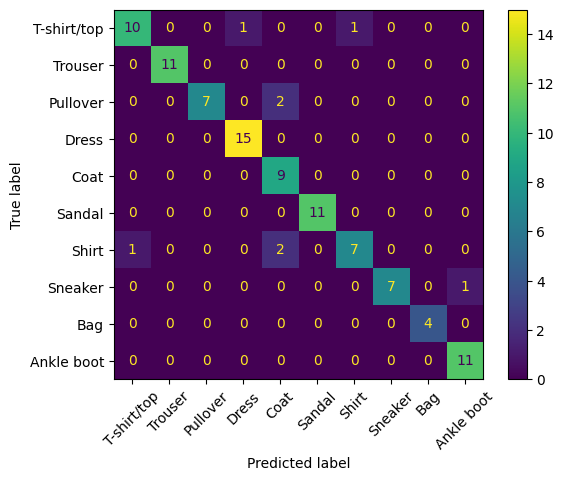

In [201]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_val, y_hat)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=45)


### Backpropagation i Torch

#### Autograd, reverse-mode autodiff i pytorch



$f(x) = x^2$

$f(5) = 25$

$f'(x) = 2x$

$f'(5) = 10$

In [202]:
x = torch.tensor(5.0, requires_grad=True)
f = x ** 2
f

tensor(25., grad_fn=<PowBackward0>)

In [203]:
f.backward() # reverse-mode auto-diff
x.grad # f och x är kopplade tack vare requires_grad!

tensor(10.)

#### Gradient descent

In [204]:
learning_rate = 0.1 # hur stort steg vi tar
x = torch.tensor(5.0, requires_grad=True)
for iteration in range(100):
    f = x**2 # framåt passet, beräkna alla värden
    f.backward() # bakåtpasset genom beräkningsgrafen
    # gradient descent
    with torch.no_grad(): # koppla inte till gradienterna! vi vill räkna om dem senare
        x -= learning_rate * x.grad
    x.grad.zero_() # sätt gradienterna till 0 så vi räknar om från början



In [205]:
x # går mot 0, eftersom x^2 har sitt minimum där!

tensor(1.0185e-09, requires_grad=True)

### Linjär regression med pytorch

In [206]:
X_train, X_rest, y_train, y_rest = train_test_split(housing.data, housing.target, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.2)
print(f"Training set: {X_train.shape, y_train.shape}\nValidation set: {X_val.shape, y_val.shape}\nTest set: {X_test.shape, y_test.shape}")

Training set: ((12384, 8), (12384,))
Validation set: ((6604, 8), (6604,))
Test set: ((1652, 8), (1652,))


In [207]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
means = X_train.mean(dim = 0, keepdim=True)
stds = X_train.std(dim=0, keepdims=True)
X_train = (X_train - means) / stds
X_val = (X_val - means) / stds
X_test = (X_test - means) / stds

In [208]:
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)


In [209]:
n_features = X_train.shape[1]
w = torch.randn((n_features, 1), requires_grad=True) # initialisera med slumpässiga vikter
b = torch.tensor(0., requires_grad=True)


##### Batch Gradient Descent

In [210]:
learning_rate = 0.1
n_epochs = 100
for epoch in range(n_epochs):
    y_pred = X_train @ w + b
    loss = ((y_pred - y_train)**2).mean() # MSE
    loss.backward()
    with torch.no_grad():
        b -= learning_rate * b.grad
        w -= learning_rate * w.grad
        b.grad.zero_()
        w.grad.zero_()
    print(f"Epoch {epoch +1}/{n_epochs}, Loss: {loss.item()}")


Epoch 1/100, Loss: 12.841644287109375
Epoch 2/100, Loss: 7.803040504455566
Epoch 3/100, Loss: 5.002476215362549
Epoch 4/100, Loss: 3.3943331241607666
Epoch 5/100, Loss: 2.4455926418304443
Epoch 6/100, Loss: 1.8728526830673218
Epoch 7/100, Loss: 1.519796371459961
Epoch 8/100, Loss: 1.2975541353225708
Epoch 9/100, Loss: 1.154382348060608
Epoch 10/100, Loss: 1.0595959424972534
Epoch 11/100, Loss: 0.994742751121521
Epoch 12/100, Loss: 0.9486064910888672
Epoch 13/100, Loss: 0.9143112301826477
Epoch 14/100, Loss: 0.8876120448112488
Epoch 15/100, Loss: 0.8658720850944519
Epoch 16/100, Loss: 0.8474438190460205
Epoch 17/100, Loss: 0.8312911987304688
Epoch 18/100, Loss: 0.8167580366134644
Epoch 19/100, Loss: 0.8034253120422363
Epoch 20/100, Loss: 0.7910221815109253
Epoch 21/100, Loss: 0.7793712615966797
Epoch 22/100, Loss: 0.7683534622192383
Epoch 23/100, Loss: 0.7578872442245483
Epoch 24/100, Loss: 0.7479148507118225
Epoch 25/100, Loss: 0.7383937239646912
Epoch 26/100, Loss: 0.7292910814285278


In [211]:
with torch.no_grad():
    y_pred = X_val @ w + b
    

In [212]:
root_mean_squared_error(y_val, y_pred)

0.7334422469139099

#### Direkt med pytorch

In [213]:
import torch.nn as nn
model = nn.Linear(in_features=n_features, out_features=1)


In [214]:
model.bias

Parameter containing:
tensor([0.0048], requires_grad=True)

In [215]:
model.weight

Parameter containing:
tensor([[ 0.3408,  0.2314, -0.3480,  0.0499,  0.2739, -0.3105, -0.1134, -0.0180]],
       requires_grad=True)

In [216]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.3408,  0.2314, -0.3480,  0.0499,  0.2739, -0.3105, -0.1134, -0.0180]],
       requires_grad=True)
Parameter containing:
tensor([0.0048], requires_grad=True)


In [217]:
model(X_train[:2])

tensor([[-0.4869],
        [ 0.2360]], grad_fn=<AddmmBackward0>)

In [218]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

mse = nn.MSELoss()

In [219]:
def train_bgd(model, optimizer, criterion, X_train, y_train, n_epochs):
    for epoch in range(n_epochs):
        y_pred = model(X_train) # hela träningssettet, alltså Batch Gradient Descent
        loss = criterion(y_pred, y_train) # optimeringsvillkor, kostnadsfunktion, loss function
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")


In [220]:
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs)

Epoch 1/100, Loss: 5.4593377113342285
Epoch 2/100, Loss: 3.6504786014556885
Epoch 3/100, Loss: 2.530421018600464
Epoch 4/100, Loss: 1.8272593021392822
Epoch 5/100, Loss: 1.3819072246551514
Epoch 6/100, Loss: 1.0981436967849731
Epoch 7/100, Loss: 0.9165000915527344
Epoch 8/100, Loss: 0.7997226119041443
Epoch 9/100, Loss: 0.7242807149887085
Epoch 10/100, Loss: 0.6752375960350037
Epoch 11/100, Loss: 0.6430832147598267
Epoch 12/100, Loss: 0.6217504739761353
Epoch 13/100, Loss: 0.6073644757270813
Epoch 14/100, Loss: 0.5974484086036682
Epoch 15/100, Loss: 0.5904173851013184
Epoch 16/100, Loss: 0.5852572917938232
Epoch 17/100, Loss: 0.5813180208206177
Epoch 18/100, Loss: 0.5781829357147217
Epoch 19/100, Loss: 0.5755844712257385
Epoch 20/100, Loss: 0.5733503103256226
Epoch 21/100, Loss: 0.5713695883750916
Epoch 22/100, Loss: 0.5695703029632568
Epoch 23/100, Loss: 0.5679056644439697
Epoch 24/100, Loss: 0.5663449764251709
Epoch 25/100, Loss: 0.5648679137229919
Epoch 26/100, Loss: 0.5634606480598

In [221]:
with torch.no_grad():
    y_pred = model(X_val)
root_mean_squared_error(y_val, y_pred)

0.7415125966072083

In [250]:
model = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=200),nn.ReLU(),
    nn.Linear(200, 200), nn.ReLU(),
    nn.Linear(200, 1))

optimizer = torch.optim.Adam(model.parameters())
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs*10)
with torch.no_grad():
    y_pred = model(X_val)
root_mean_squared_error(y_val, y_pred)


Epoch 1/1000, Loss: 5.454488277435303
Epoch 2/1000, Loss: 4.73338508605957
Epoch 3/1000, Loss: 4.096349239349365
Epoch 4/1000, Loss: 3.535064220428467
Epoch 5/1000, Loss: 3.047919988632202
Epoch 6/1000, Loss: 2.636687755584717
Epoch 7/1000, Loss: 2.30232310295105
Epoch 8/1000, Loss: 2.044340133666992
Epoch 9/1000, Loss: 1.8577667474746704
Epoch 10/1000, Loss: 1.7313734292984009
Epoch 11/1000, Loss: 1.648396372795105
Epoch 12/1000, Loss: 1.588788628578186
Epoch 13/1000, Loss: 1.5340394973754883
Epoch 14/1000, Loss: 1.470165491104126
Epoch 15/1000, Loss: 1.3907647132873535
Epoch 16/1000, Loss: 1.2970789670944214
Epoch 17/1000, Loss: 1.1952159404754639
Epoch 18/1000, Loss: 1.094038724899292
Epoch 19/1000, Loss: 1.0020620822906494
Epoch 20/1000, Loss: 0.9244264364242554
Epoch 21/1000, Loss: 0.8638162016868591
Epoch 22/1000, Loss: 0.8204340934753418
Epoch 23/1000, Loss: 0.7919554114341736
Epoch 24/1000, Loss: 0.7750020027160645
Epoch 25/1000, Loss: 0.7658496499061584
Epoch 26/1000, Loss: 0.

0.5267035365104675